In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
import pose_input

# %matplotlib inline
# import matplotlib.pyplot as plt
slim = tf.contrib.slim

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
LABEL_SIZE = 46
NUM_STAGES = 2

batch_norm_params = {
    # Decay for the moving averages.
    'decay': 0.9997,
    # epsilon to prevent 0s in variance.
    'epsilon': 0.001,
    # collection containing update_ops.
    'updates_collections': tf.GraphKeys.UPDATE_OPS,
    # collection containing the moving mean and moving variance.
    'variables_collections': {
        'beta': None,
        'gamma': None,
        'moving_mean': ['moving_vars'],
        'moving_variance': ['moving_vars'],
    }
}

def inference(images,weight_decay):
    """Build a human pose model.
    Args:
        images: Images returned from distorted_inputs() or inputs().
    Returns:
        Logits.
    """
    bgr = images[:,:,:,:3]
    centermap = images[:,:,:,3]
    centermap = tf.expand_dims(centermap,3)
    resized_centermap = tf.image.resize_images(centermap,[LABEL_SIZE,LABEL_SIZE])
    
    with slim.arg_scope([slim.conv2d], padding='SAME',
                        weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        weights_regularizer=slim.l2_regularizer(weight_decay),
                        normalizer_fn=slim.batch_norm, # apply batchnorm after each conv layer
                        normalizer_params=batch_norm_params):
        # stage 0
        net0 = slim.conv2d(bgr, 16, [3, 3], scope='conv0_stage0')
        net0 = slim.conv2d(net0, 16, [3, 3], scope='conv1_stage0')
        net0 = slim.conv2d(net0, 16, [3, 3], rate=2, scope='conv2_stage0')
        net0 = slim.max_pool2d(net0, [2, 2], scope='pool0_stage0')

        net0 = slim.conv2d(net0, 32, [3, 3], scope='conv3_stage0')
        net0 = slim.conv2d(net0, 32, [3, 3], scope='conv4_stage0')
        net0 = slim.conv2d(net0, 32, [3, 3], rate=2, scope='conv5_stage0')
        net0 = slim.max_pool2d(net0, [2, 2], scope='pool1_stage0')

        net0 = slim.conv2d(net0, 64, [3, 3], scope='conv6_stage0')
        net0 = slim.conv2d(net0, 64, [3, 3], scope='conv7_stage0')
        net0 = slim.conv2d(net0, 64, [3, 3], rate=2, scope='conv8_stage0')
        net0 = slim.max_pool2d(net0, [2, 2], scope='pool2_stage0')    

        net0 = slim.conv2d(net0, 128, [3, 3], scope='conv9_stage0')
        net0 = slim.conv2d(net0, 128, [3, 3], scope='conv10_stage0')
        net0 = slim.conv2d(net0, 128, [3, 3], rate=2, scope='conv11_stage0')
        net0 = slim.conv2d(net0, 128, [3, 3], rate=2, scope='conv12_stage0')
        net0 = slim.conv2d(net0, 128, [1, 1], scope='fc0_stage0')
        net0 = slim.conv2d(net0, pose_input.NUM_HEATMAPS, [1, 1], 
                           activation_fn=None,
                           scope='fc1_stage0')
        # stage 1
        net1 = slim.conv2d(images, 16, [3, 3], scope='conv0_stage1')
        net1 = slim.conv2d(net1, 16, [3, 3], scope='conv1_stage1')
        net1 = slim.conv2d(net1, 16, [3, 3], rate=2, scope='conv2_stage1')
        net1 = slim.max_pool2d(net1, [2, 2], scope='pool0_stage1')

        net1 = slim.conv2d(net1, 32, [3, 3], scope='conv3_stage1')
        net1 = slim.conv2d(net1, 32, [3, 3], scope='conv4_stage1')
        net1 = slim.conv2d(net1, 32, [3, 3], rate=2, scope='conv5_stage1')
        net1 = slim.max_pool2d(net1, [2, 2], scope='pool1_stage1')
        
        net1 = slim.conv2d(net1, 64, [3, 3], scope='conv6_stage1')
        net1 = slim.conv2d(net1, 64, [3, 3], scope='conv7_stage1')
        net1 = slim.conv2d(net1, 64, [3, 3], rate=2, scope='conv8_stage1')
        net1 = slim.max_pool2d(net1, [2, 2], scope='pool2_stage1')
        
        net1 = slim.conv2d(net1, 128, [3, 3], scope='conv9_stage1')
        net1_conv10 = slim.conv2d(net1, 32, [3, 3], scope='conv10_stage1')
        
        net1 = tf.concat(3,[net1_conv10,net0,resized_centermap])
        net1 = slim.conv2d(net1, 128, [3, 3], scope='conv11_stage1')
        net1 = slim.conv2d(net1, 128, [3, 3], scope='conv12_stage1')
        net1 = slim.conv2d(net1, 128, [3, 3], rate=2, scope='conv13_stage1')
        net1 = slim.conv2d(net1, 128, [3, 3], rate=4, scope='conv14_stage1')
        net1 = slim.conv2d(net1, 128, [3, 3], rate=8, scope='conv15_stage1')
        net1 = slim.conv2d(net1, 128, [1, 1], scope='fc0_stage1')
        net1 = slim.conv2d(net1, pose_input.NUM_HEATMAPS, [1, 1], 
                           activation_fn=None,
                           scope='fc1_stage1')
        # concatenate outputs
        output = tf.concat(3,[net0,net1])
    return output

def loss(heatmaps, labels):
    """Add L2Loss to all the trainable variables.
    Add summary for "Loss" and "Loss/avg".
    Args:
        logits: Logits from inference().
        labels: Labels from distorted_inputs or inputs().
    Returns:
        Loss tensor of type float.
    """
    resized_labels = tf.image.resize_images(labels,[LABEL_SIZE,LABEL_SIZE])
    # labels_self contain heatmaps that only include self joints
    # They are used for contextual stages of training
    # labels_all contain heatmaps that include other people's joints
    # They are used for training local detectors
    labels_all,labels_self = tf.split(3, 2, resized_labels)
    heatmap_all,heatmap_self = tf.split(3, NUM_STAGES, heatmaps)
    # stage 0 loss
    loss0_tensor = tf.nn.sigmoid_cross_entropy_with_logits(heatmap_all,labels_all)
    loss0 = tf.reduce_mean(loss0_tensor)
    tf.contrib.losses.add_loss(loss0)
    # stage 1 loss
    loss1_tensor = tf.nn.sigmoid_cross_entropy_with_logits(heatmap_self,labels_self)
    loss1 = tf.reduce_mean(loss1_tensor)
    tf.contrib.losses.add_loss(loss1)
    # The total loss is defined as the Euclidean loss plus all of the weight
    # decay terms (L2 loss).
    return slim.losses.get_total_loss()


In [3]:
# DIRECTORY = '/Users/xuehan.xiong/Google Drive/datasets/human_pose'
# TFRECORD_FILE = os.path.join(DIRECTORY, 'MPI_train.tfrecords')

# file_path = os.path.join(DIRECTORY,TFRECORD_FILE)
# images,labels = pose_input.distorted_inputs([file_path],32,1000)
# heatmaps = inference(images,1.0E-5)
# heatmap_loss = loss(heatmaps, labels)
# init = tf.initialize_all_variables()

# sess = tf.InteractiveSession()
# sess.run(init)
# # Start the queue runners.
# tf.train.start_queue_runners(sess=sess)



Filling queue with 50 images before starting to train. This will take a few minutes.


[<Thread(Thread-15, started daemon 123145445429248)>,
 <Thread(Thread-16, started daemon 123145449635840)>,
 <Thread(Thread-17, started daemon 123145453842432)>]

0.997754
0.0


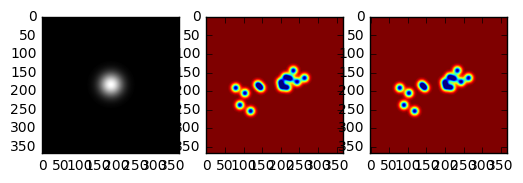

In [8]:
# loss_val = sess.run(heatmap_loss)
# print loss_val
# images_val,labels_val = sess.run([images,labels])
# print np.amax(labels_val[0,:,:,0])
# print np.amin(labels_val[0,:,:,0])
# plt.subplot(131)
# plt.imshow(images_val[0,:,:,3],cmap='gray')
# plt.subplot(132)
# plt.imshow(labels_val[0,:,:,14])
# plt.subplot(133)
# plt.imshow(labels_val[0,:,:,29])
# plt.show()